In [2]:
from obspy.clients.fdsn import Client
import math as M
from obspy import UTCDateTime
from obspy import read
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
iris = Client('IRIS')
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')

In [3]:
def dt2ts(dt):
    """Converts a datetime object to UTC timestamp

    naive datetime will be considered UTC.

    """

    return calendar.timegm(dt.utctimetuple())

# function from https://docs.obspy.org/_modules/obspy/imaging/spectrogram.html#_nearest_pow_2:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

# traceplot/spectrogram function
def spec(data, figsize=(15,12), gain=10):
    '''
    Takes an obspy data stream
    
    Outputs a trace plot and spectrogram combined figure
    '''
    try:
        data = data.merge()[0]                      # merge all traces down to one (obspy likes to split them)
    except:
        data = data[0]                              # if that doesn't work, take the first one


    freq = data.stats.sampling_rate                 # sampling frequency in Hz of rshake (1D = 50; 3D & 4D = 100)
    start = data.stats.starttime
    end = data.stats.endtime
    seconds = end - start                           # timedelta containing number of seconds of data to display
    mplstart = dt2ts(data.times('utcdatetime')[0])
    mplend = dt2ts(data.times('utcdatetime')[-1])
    name = '%s.%s.%s.%s' % (data.stats.network, data.stats.station, data.stats.location, data.stats.channel)

    npts = data.stats.npts
    wlen = freq / 100
    per_lap = 0.9
    mult = 8.0

    
    nfft = int(_nearest_pow_2(wlen * freq))
    nlap = int(nfft * per_lap)
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft

    #initialize the graph and settings
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize, facecolor='white')

    ax1.set_xlim(0, npts)                           # being explicit here helps speed things up slightly
    ax1.set_ylim(min(data.data)-25, max(data.data)+25)

    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))
        nlap = int(nfft * per_lap)
    specgram = ax2.specgram(data.data, NFFT=nfft, pad_to=mult, Fs=freq, noverlap=nlap)[0] # take only the spectrogram
    specgram = np.flipud(specgram**(1/gain))        # flip and apply nth root gain
    
    # Create your x-limits. Using two of your unix timestamps you first
    # create a list of datetime.datetime objects using map.
    x_lims = list(map(datetime.utcfromtimestamp, [mplstart, mplend]))

    # You can then convert these datetime.datetime objects to the correct
    # format for matplotlib to work with.
    x_lims = mdates.date2num(x_lims)
    
    ax1.set(title='%s - %s - %s - %sHz' % (name, start, end, freq), ylabel='Counts')
    ax1.plot(data, 'k-', linewidth=0.5)

    ax2.set(xlabel='UTC Date / Time', ylabel='Frequency (Hz)')
    ax2.imshow(specgram, interpolation='nearest', extent=[x_lims[0], x_lims[1],  0, freq/2], aspect='auto')

    #ax1.xaxis_date()
    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%Y.%j - %H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax1.tick_params(bottom=False)
    ax2.tick_params(bottom=True, top=True, length=10)
    
    plt.show()

# Event query
### Stations
##### AM -  Raspberry Shake
- [AM.R4989](#AM.R4989)
- [AM.RB489](#AM.RB489)
- [AM.R35E7](#AM.R35E7)
- [AM.RCB43](#AM.RCB43)

##### US - USArray
- [US.PKME](#US.PKME)

##### NE - New England Seismic Network
- [NE.ORNO aka AM.R6F62](#NE.ORNO)
- [NE.EMMW](#NE.EMMW)
- [NE.PQI](#NE.PQI)
- [NE.WVL](#NE.WVL)

##### N4 - Central and Eastern US
- [N4.G65A](#N4.G65A)
- [N4.F64A](#N4.F64A)
- [N4.I63A](#N4.I63A)
- [N4.F63A](#N4.F63A)

In [18]:
start_1 = "2018-09-21 16:15:00"
end_1 = "2018-09-21 16:17:00"
starttime = UTCDateTime(start_1)
endtime = UTCDateTime(end_1)

freqmin = 0.5         # highpass

### AM.R4989
#### Raspberry Shake R4989 - Orono, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


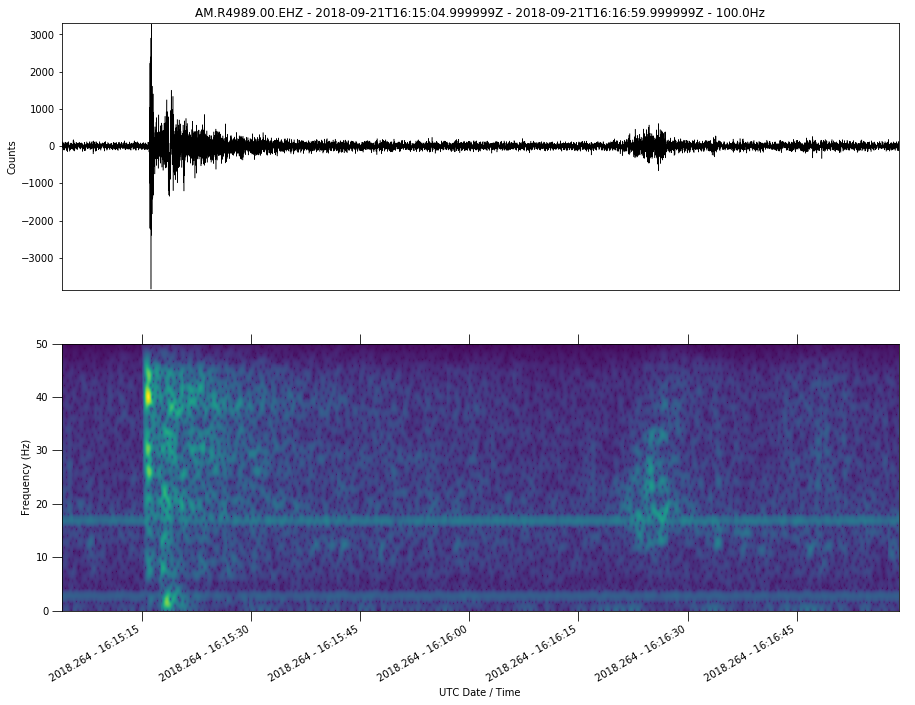

In [19]:
q1 = rs.get_waveforms('AM', 'R4989', '00', 'EHZ', starttime, endtime)
f = q1.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=5), endtime)
#f = f.detrend()
spec(f, gain=6)

### AM.RB489
#### Raspberry Shake RB489 - Pigeon Hill, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


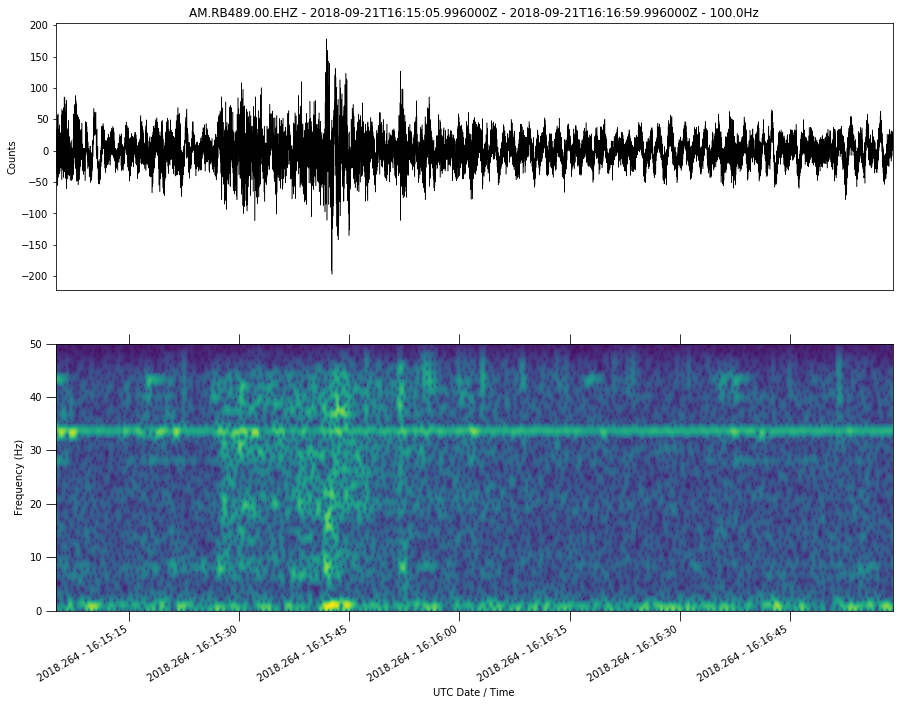

In [20]:
q2 = rs.get_waveforms('AM', 'RB489', '00', 'EHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### AM.R35E7
#### Raspberry Shake R35E7 - West Poland, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


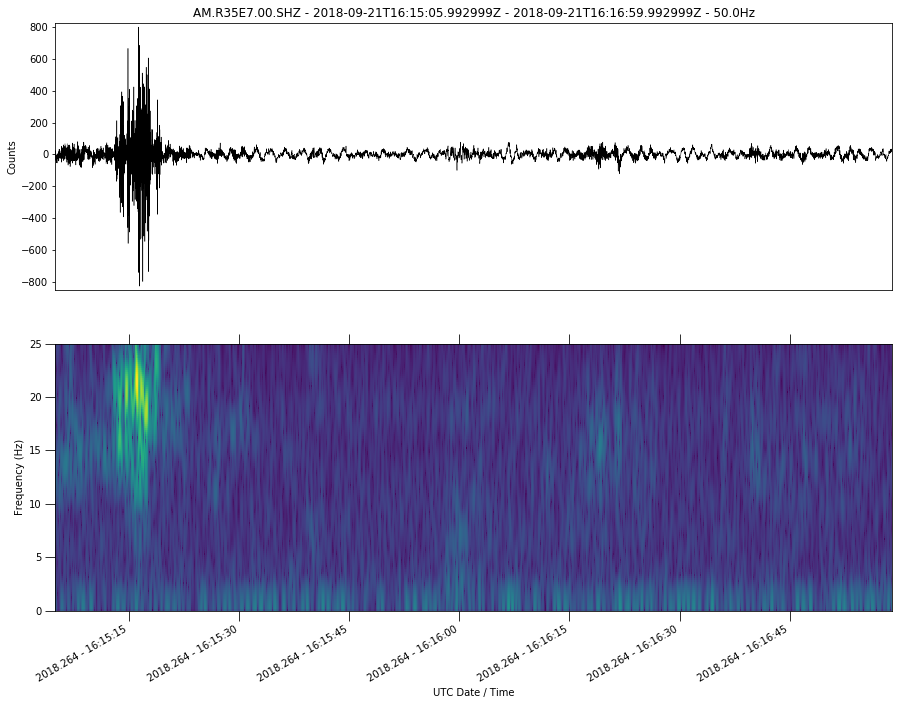

In [21]:
q2 = rs.get_waveforms('AM', 'R35E7', '00', 'SHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### AM.RCB43
#### Raspberry Shake RCB43 - Williamstown, MA ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


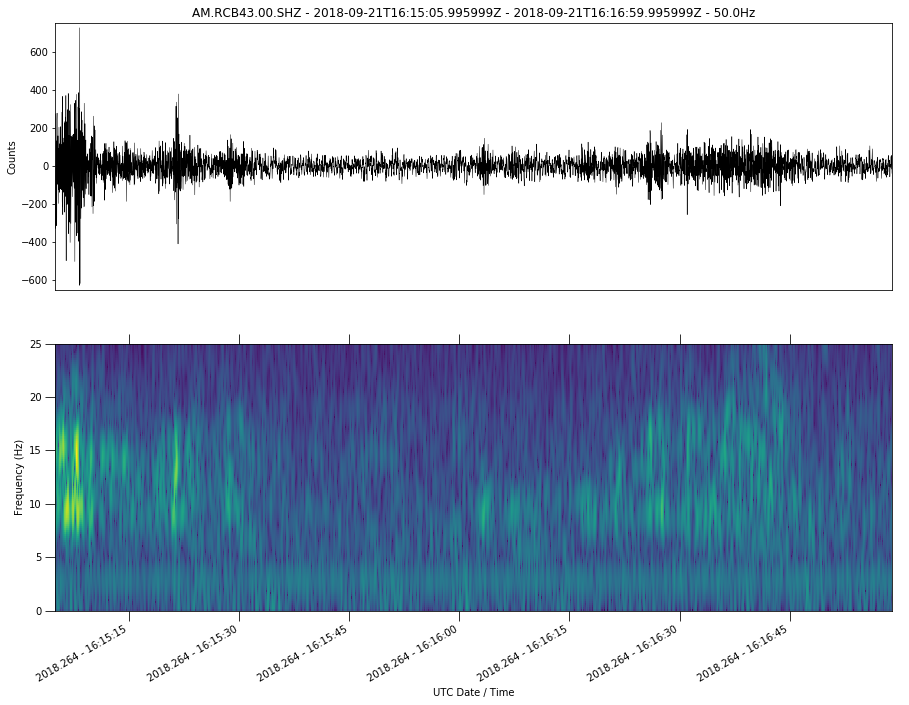

In [22]:
q2 = rs.get_waveforms('AM', 'RCB43', '00', 'SHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### US.PKME
#### USArray station US.PKME, Peaks-Kenny, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


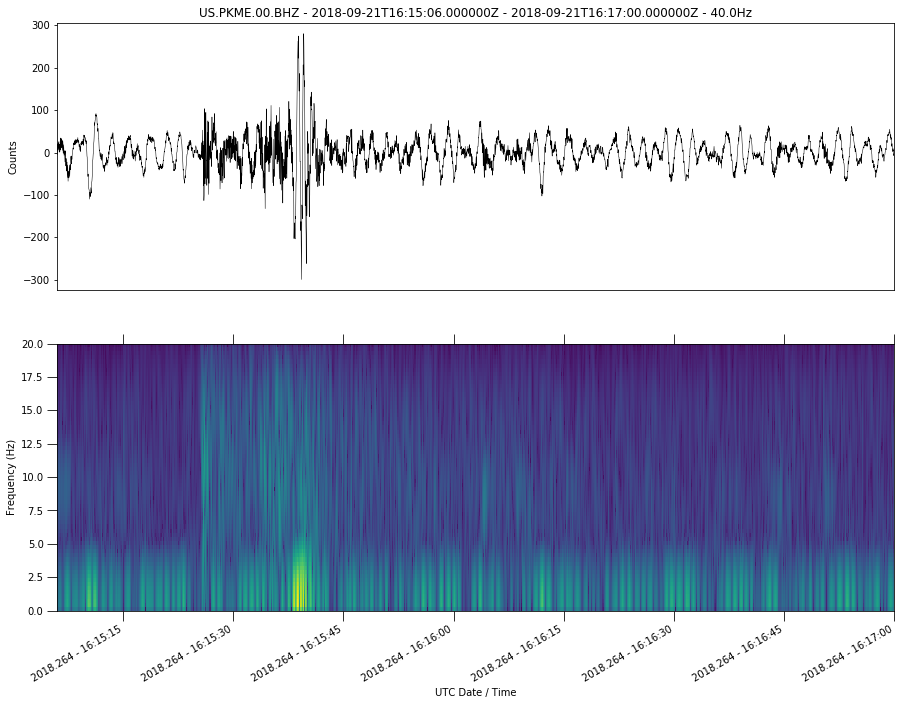

In [23]:
q3 = iris.get_waveforms('US', 'PKME', '00', 'BHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### NE.ORNO
#### NESN Station NE.ORNO -  University seismic vault, Orono, ME ([back](#Event-query))
##### AKA Raspberry Jam R6F62

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


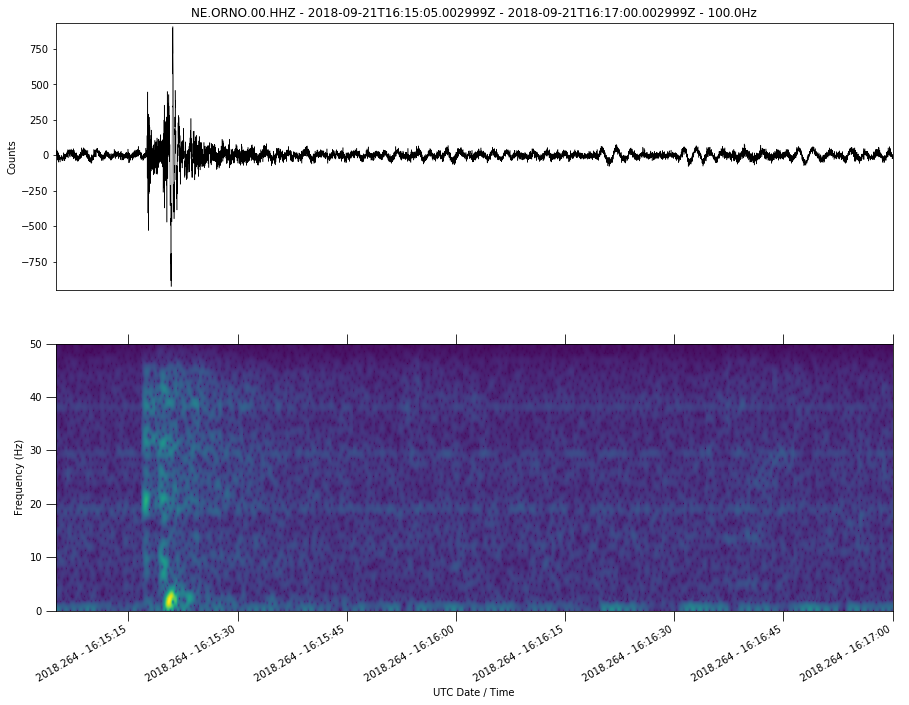

In [24]:
q3 = read('../../seismic/AM.R6F62.00.EHZ.D.2018.264')
q3 = q3.slice(starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=5), endtime)
#f = f.detrend()
f[0].stats.station = 'ORNO'
f[0].stats.network = 'NE'
f[0].stats.channel = 'HHZ'
spec(f, gain=6)

### NE.EMMW
#### NESN Station EMMW - Machias, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


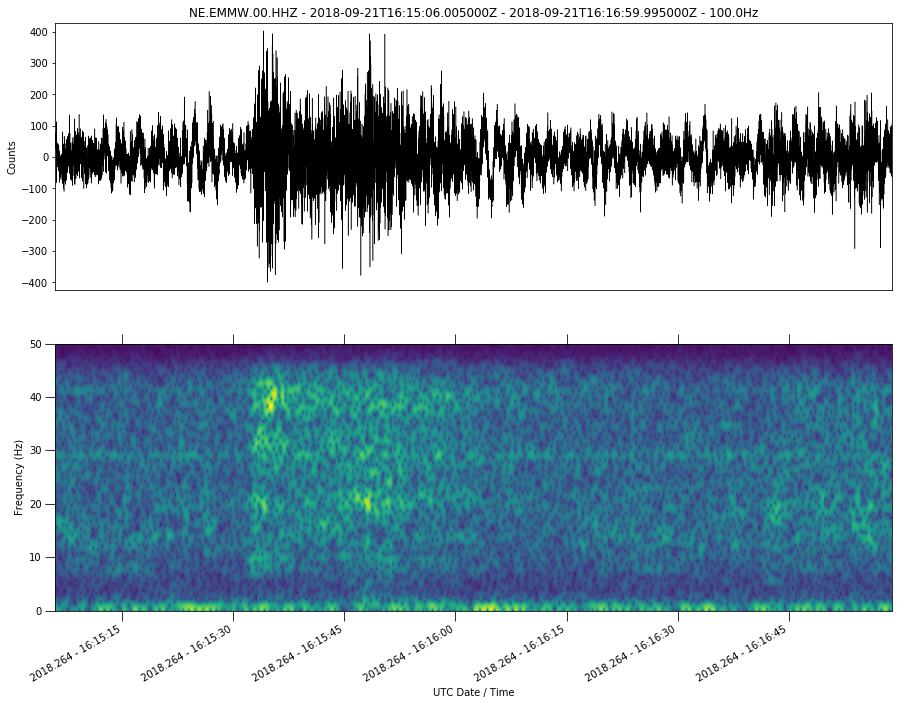

In [25]:
q3 = iris.get_waveforms('NE', 'EMMW', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### NE.PQI
#### NESN Station PQI - Presque Isle, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


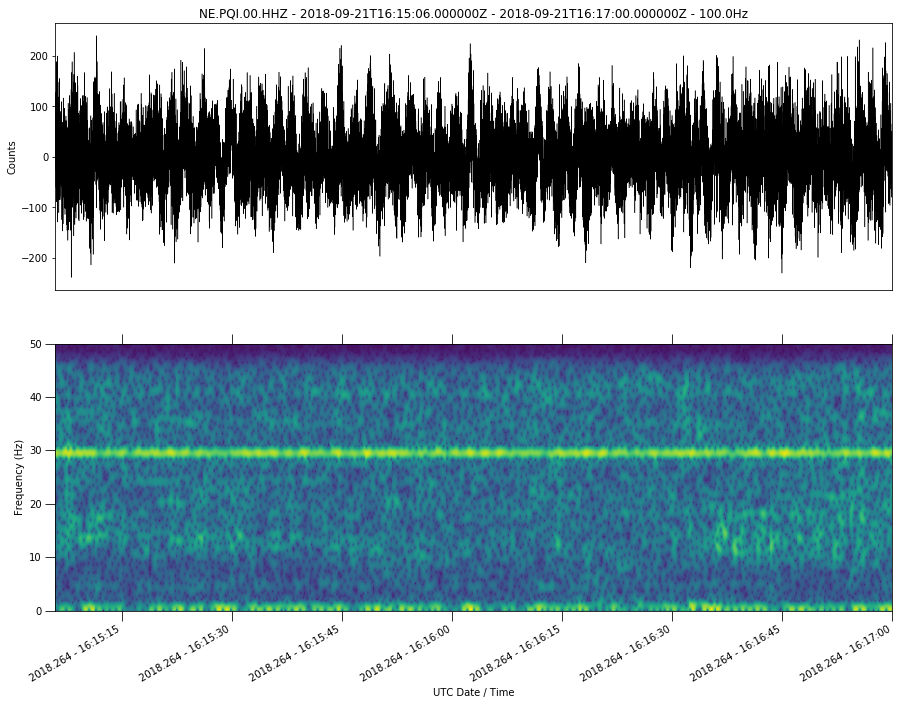

In [26]:
q3 = iris.get_waveforms('NE', 'PQI', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### NE.WVL
#### NESN Station WVL - Colby College, Waterville, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


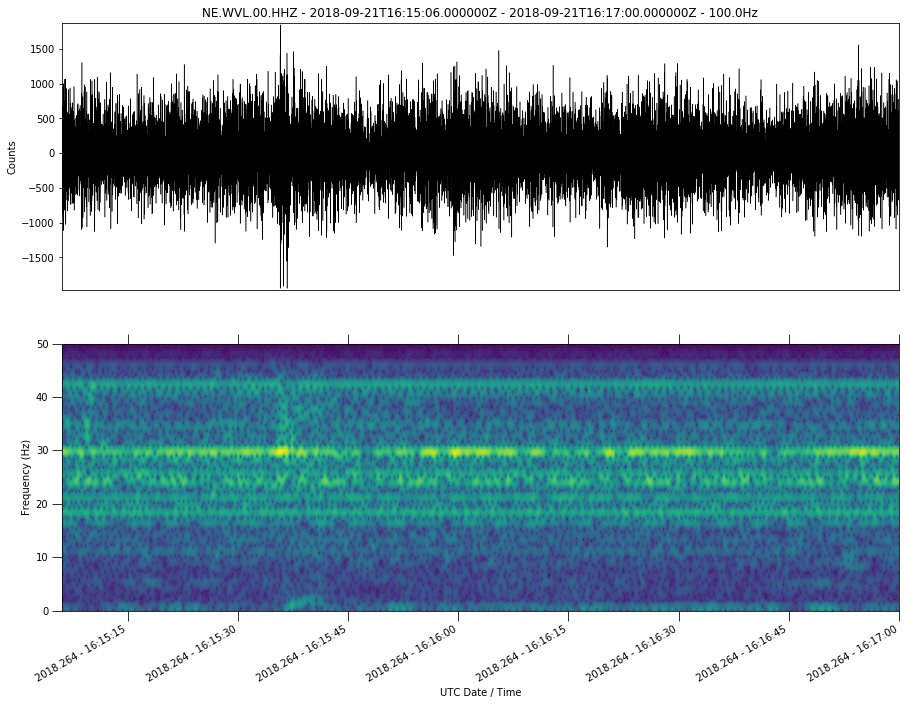

In [27]:
q3 = iris.get_waveforms('NE', 'WVL', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
spec(f, gain=6)

### N4.G65A
#### Central and Eastern US Station G65A - Princeton, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


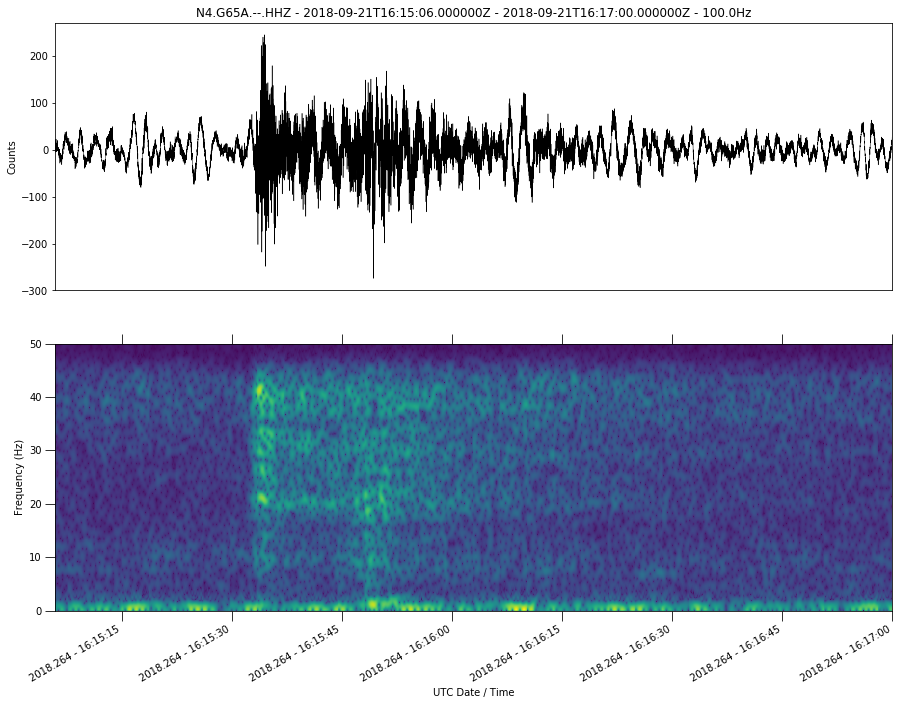

In [28]:
q3 = iris.get_waveforms('N4', 'G65A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
f[0].stats.location = '--'
spec(f, gain=6)

### N4.F64A
#### Central and Eastern US Station F64A - Sherman, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


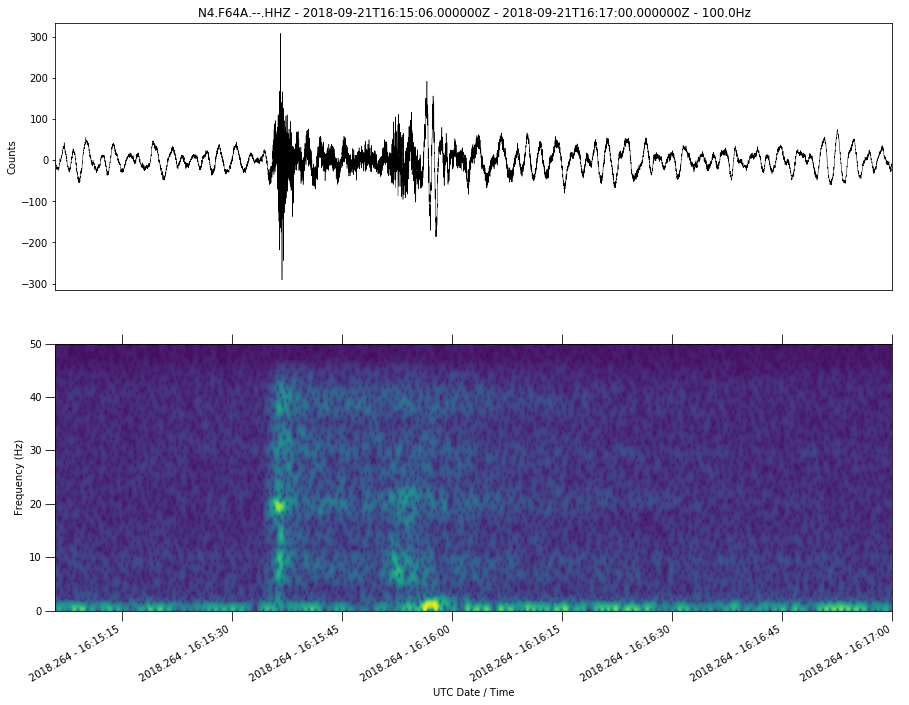

In [29]:
q3 = iris.get_waveforms('N4', 'F64A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
f[0].stats.location = '--'
spec(f, gain=6)

### N4.I63A
#### Central and Eastern US Station I63A - Otisfield, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


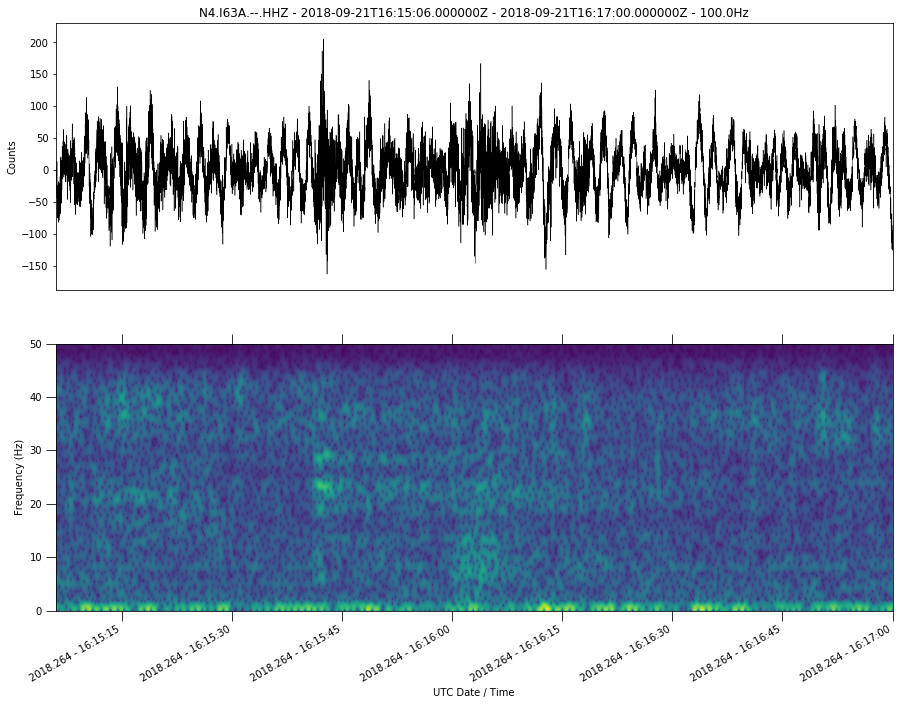

In [30]:
q3 = iris.get_waveforms('N4', 'I63A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
f[0].stats.location = '--'
spec(f, gain=6)

### N4.F63A
#### Central and Eastern US Station F63A - Nahmakanta Public Land, Browneville, ME ([back](#Event-query))

In [31]:
q3 = iris.get_waveforms('N4', 'F63A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
#f = f.detrend()
f[0].stats.location = '--'
spec(f, gain=6)

FDSNNoDataException: No data available for request.
Detailed response of server:

